In [1]:
import numpy as np
bases = ['A', 'C', 'G', 'T']
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
# file result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_taggart.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [4]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

22020
184272


In [ ]:
# Used to compare to branchpointer (Commented so I don't accidently re-run..)
# c = 0
# with open('../anno/test_taggart_valid.tsv', 'w') as fp:
#     ID = 0
#     fp.write('\t'.join(['id', 'chromsome', 'start', 'end', 'strand']) + '\n')
#     for (chrom, three, strand), bp in introns.items():
#         if not bp or chrom not in ['chr1', 'chr2', 'chr3', 'chr4', 'chr5']:
#             continue
#         if strand == '+':
#             begin, end = str(three - 70), str(three)
#         else:
            
#             begin, end = str(three+1), str(three + 70+1)
#         c += 1
#         fp.write('\t'.join(["{}_{}_{}".format(chrom, three, strand),
#                             chrom, begin, end, strand]) + '\n')
# print c

In [5]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns):
    X, y, chroms, coords, strands = [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        X += [onehot(seq).reshape(1, L, 4)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three - 1
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
            
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords), np.array(strands))

X, y, chroms, coords, strands = encode(known)


print np.sum(y == 1)
print np.sum(y == -1)
print X.shape

25324
0
(22020, 70, 4)


In [6]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_train.shape, y_valid.shape, y_test.shape

2342 4568 15110
(15110, 70, 4) (4568, 70, 4) (2342, 70, 4)
(15110, 70) (4568, 70) (2342, 70)


In [7]:
X_test = np.vstack([X_test, X_valid])
y_test = np.vstack([y_test, y_valid])

chroms = np.hstack([chroms[test], chroms[valid]])
coords = np.hstack([coords[test], coords[valid]])
strands = np.hstack([strands[test], strands[valid]])

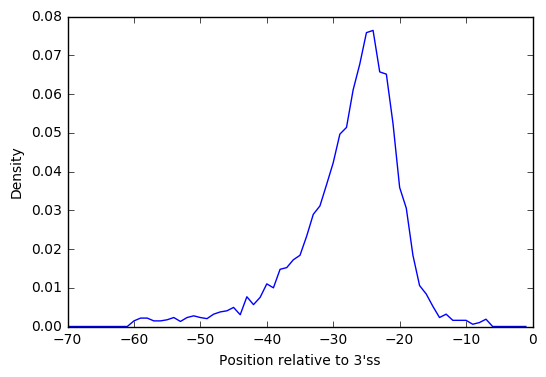

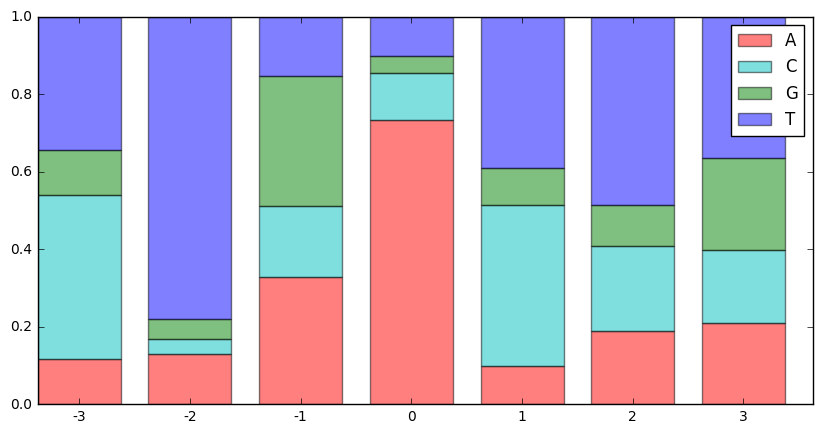

In [10]:
def pwm_logo(pwm, title = '', K = 3):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()

def sanity_check(X, y):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        if np.max(target) == -float('inf'): continue
        bp = np.argmax(target)
        counts[bp] += 1
        total += 1
    dists = counts / float(total)
    plt.plot(range(-70, 0), dists)
    plt.ylabel('Density')
    plt.xlabel("Position relative to 3'ss")
    plt.show()

    K = 3
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
    pwm = counts / total
    pwm_logo(pwm)
    
sanity_check(X_test, y_test)

# Load model

In [11]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


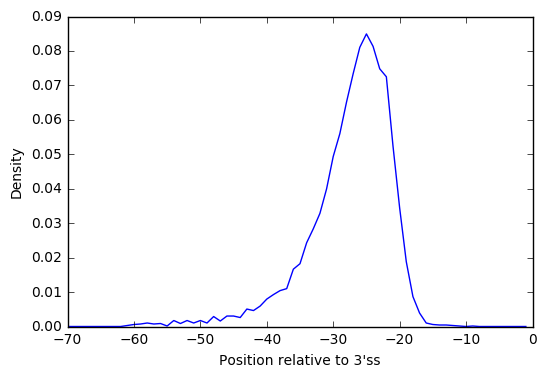

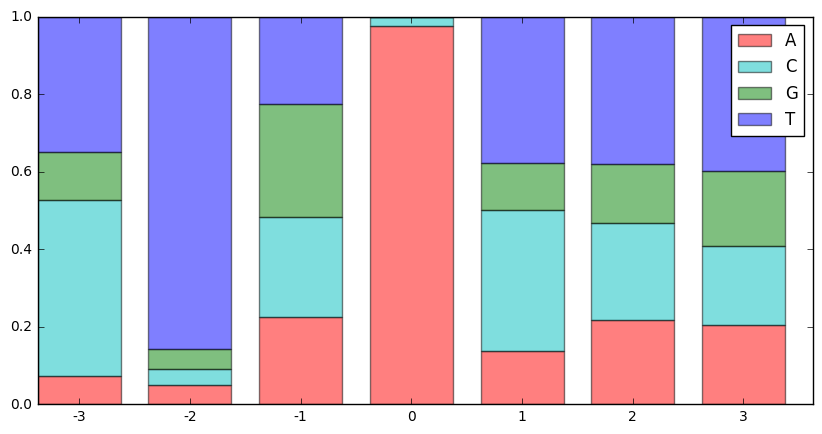

In [12]:
test_preds = model.predict(X_test[:, :, :4]).reshape(-1, 70)
sanity_check(X_test, test_preds)

# Load SVM-BPFinder Predictions
- Cloned current version of SVM-BPFinder from https://bitbucket.org/regulatorygenomicsupf/svm-bpfinder.
- Produced fasta file of length 70 intronic sequences aligned to 3'ss using labranchor/create_fasta.py using hg19 and gencode v19.
- Ran SVM-BPFinder with command "svm-bpfinder/svm_bpfinder.py -i labranchor/gencode.v19.fa -s Hsap -d 15 > svm-bpfinder.tsv"
- Choose best branchpoint using developer recommended AGEZ heuristics. Downloaded from http://regulatorygenomics.upf.edu/Software/SVM_BP/. Command was "perl calculate_best_BP_per_intron.pl < svm_ppfinder_output.txt > best_bp_per_intron.txt".

183860566 chr3
109492543 chr2
6308


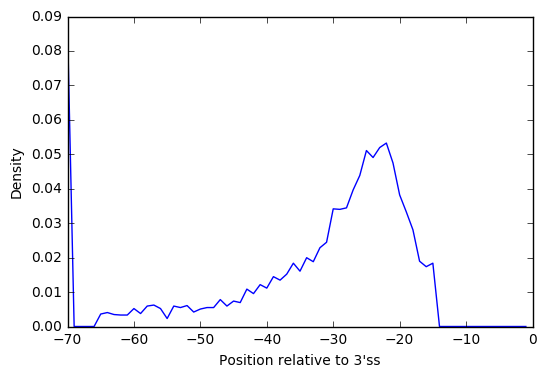

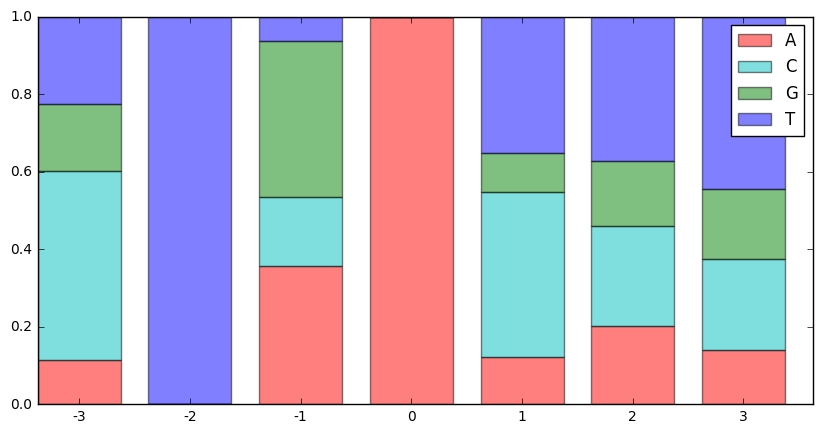

In [44]:
bpfinder = np.zeros(test_preds.shape)
p, m = 0, 0
with open('../best_bp_per_intron.txt') as fp:
    for line in fp:
        coord, agez, dist = line.split('\t')[:3]
        chrom, three, strand = coord.split(':')
        dist, three = int(dist), int(three)
        
        if strand == '-': three += 1
        score = float(line.split('\t')[-1])
        if chrom in ['chr1', 'chr2', 'chr3', 'chr4', 'chr5'] and three in coords:
            assert 0 < dist < 70
            if not sum((coords==three)*(chroms==chrom)):
                print three, chrom
            bpfinder[np.argwhere((coords==three))[0], -dist] = score

    
print sum(np.max(bpfinder, axis = 1) > 0)
sanity_check(X_test, bpfinder)

# Load Branchpointer predictions
- See preprocessing/branchpointer.taggart.R

179757
6739
(6910, 70)


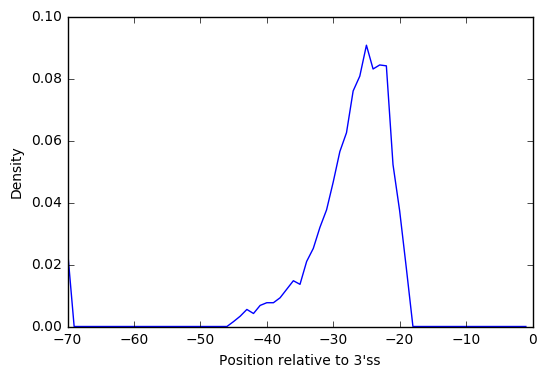

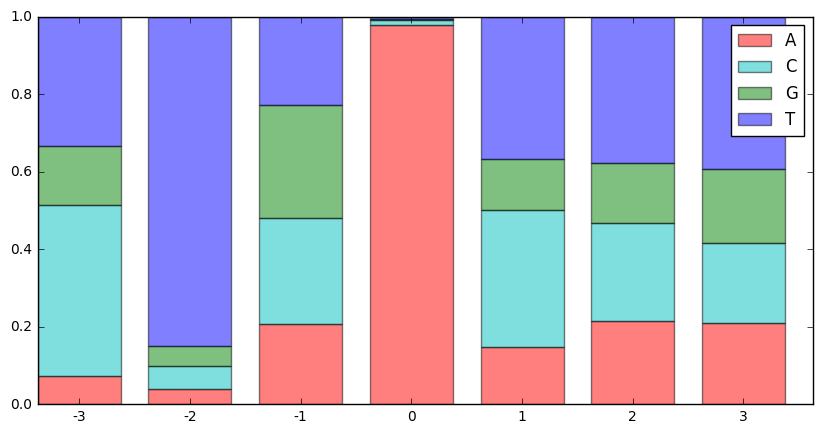

In [45]:
# Load in scores from branchpointer
pos  = []
for line in open('../anno/branchpointer.taggart.valid.pos.tsv'):
    pos += map(int, line.strip().split())
scores = []
for line in open('../anno/branchpointer.taggart.valid.score.tsv'):
    scores += map(float, line.strip().split())
bptr = {p:score for p, score in zip(pos, scores)}
print len(bptr)
bptr_preds = np.zeros((len(coords), 27))
for i, (three, strand) in enumerate(zip(coords, strands)):
    region = (range(three-44, three - 17)
              if strand == '+' else
              range(three + 45, three + 18, -1))
    #if strand == '+':continue
    for j, pos in enumerate(region):
        bptr_preds[i, j] = bptr[pos] if pos in bptr else 0
        
bptr_preds = np.hstack([np.zeros((len(coords), 25)), bptr_preds, np.zeros((len(coords), 18))])
print sum(np.max(bptr_preds, axis = 1) > 0)
print bptr_preds.shape
sanity_check(X_test, bptr_preds)

# Model Performance

In [48]:
def shifted_matching(preds, true):
    E, B = 4, 4
    total, match, shifted = 0, 0, 0
    for p, t in zip(preds, true):
        if not np.sum(t==1): continue
        bp = np.argmax(p)
        if bp in np.array(range(t.shape[0]))[t == 1]:
            match += 1
        if any(i in np.array(range(t.shape[0]))[t == 1]
                 for i in range(bp-E, bp+B+1)):
            shifted += 1
            
        total += 1

    heights = [match / float(total),  shifted / float(total)]
    return total, heights

print 'All'
print shifted_matching(test_preds, y_test)
print shifted_matching(bptr_preds, y_test)
print shifted_matching(bpfinder, y_test)
print

print '-18 to -45'
print shifted_matching(test_preds[:, -45:-18], y_test[:, -45:-18])
print shifted_matching(bptr_preds[:, -45:-18], y_test[:, -45:-18])
print shifted_matching(bpfinder[:, -45:-18], y_test[:, -45:-18])
print

print 'Only A Branchpoints'
print shifted_matching(test_preds*X_test[:, :, 0], y_test*X_test[:, :, 0])
print shifted_matching(bptr_preds*X_test[:, :, 0], y_test*X_test[:, :, 0])
print shifted_matching(bpfinder * X_test[:, :, 0], y_test*X_test[:, :, 0])
print

All
(6910, [0.5622286541244573, 0.8001447178002894])
(6910, [0.48842257597684513, 0.7254703328509406])
(6910, [0.44746743849493487, 0.5969609261939218])

-18 to -45
(6349, [0.594581823909277, 0.8401323042998897])
(6349, [0.5315797763427311, 0.7790203181603402])
(6349, [0.45818239092770513, 0.6022995747361789])

Only A Branchpoints
(5269, [0.7198709432529892, 0.84797874359461])
(5269, [0.634465743025242, 0.7680774340482065])
(5269, [0.586828620231543, 0.6731827671284873])



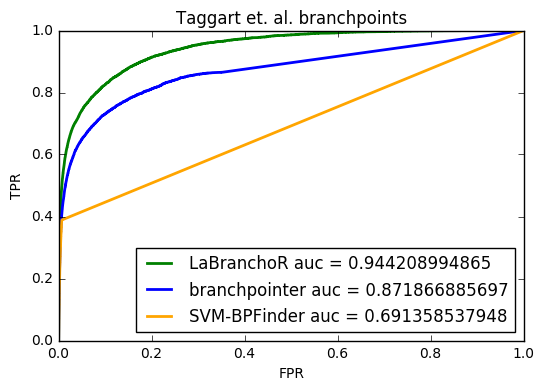

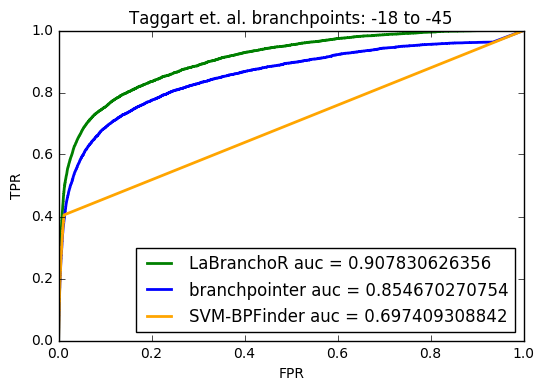

In [28]:
def roc_entry(y, pred, label, color):
    pred[pred == -float('inf')] = -100
    fpr, tpr, thresholds = metrics.roc_curve(y[y != -1],
                                             pred[y != -1],
                                             pos_label=1)
    auc = metrics.roc_auc_score(y[y != -1],
                                pred[y != -1])
    plt.plot(fpr, tpr, label = "{} auc = {}".format(label, auc), lw = 2, c = color)
    

def roc(y, preds, labels, colors, title):
    for i in range(len(preds)):
        preds[i] = preds[i][np.max(y, axis = 1)>0].flatten()
    y = y[np.max(y, axis = 1)>0].flatten()
    
    for pred, label, color in zip(preds, labels, colors):
        roc_entry(y, pred, label, color)
    plt.legend(loc = 4)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.title(title)
    plt.show()

roc(y_test, [test_preds, bptr_preds, bpfinder],
    ['LaBranchoR', 'branchpointer', 'SVM-BPFinder'],
    ['g', 'b', 'orange'], 'Taggart et. al. branchpoints')

roc(y_test[:, -45:-18], [test_preds[:, -45:-18], bptr_preds[:, -45:-18], bpfinder[:, -45:-18]],
    ['LaBranchoR', 'branchpointer', 'SVM-BPFinder'],
    ['g', 'b', 'orange'], 'Taggart et. al. branchpoints: -18 to -45')

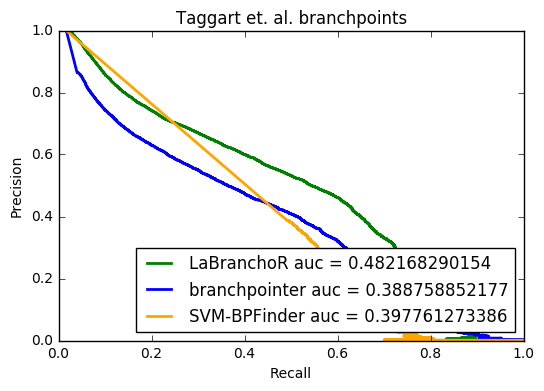

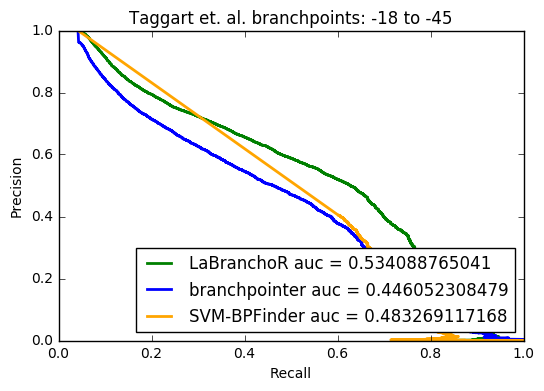

In [29]:
def prc_entry(y, pred, label, color):
    pred[pred == -float('inf')] = -100
    fpr, tpr, thresholds = metrics.precision_recall_curve(y[y != -1],
                                                          pred[y != -1],
                                                          pos_label=1)
    auc = metrics.average_precision_score(y[y != -1],
                                          pred[y != -1])
    plt.plot(fpr, tpr, label = "{} auc = {}".format(label, auc), lw = 2, c = color)
    

def prc(y, preds, labels, colors, title):
    for i in range(len(preds)):
        preds[i] = preds[i][np.max(y, axis = 1)>0].flatten()
    y = y[np.max(y, axis = 1)>0].flatten()
    
    for pred, label, color in zip(preds, labels, colors):
        prc_entry(y, pred, label, color)
    plt.legend(loc = 4)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title(title)
    plt.show()

prc(y_test, [test_preds, bptr_preds, bpfinder],
    ['LaBranchoR', 'branchpointer', 'SVM-BPFinder'],
    ['g', 'b', 'orange'], 'Taggart et. al. branchpoints')

prc(y_test[:, -45:-18], [test_preds[:, -45:-18], bptr_preds[:, -45:-18], bpfinder[:, -45:-18]],
    ['LaBranchoR', 'branchpointer', 'SVM-BPFinder'],
    ['g', 'b', 'orange'], 'Taggart et. al. branchpoints: -18 to -45')